# Fitting DLT with Complex Seasonality - Daily Forecast Example

There are some challenges to fit complex seasonality with LGT/DLT. Although one should usually look into some models such as **Kernel-based Time-varying Regression(KTR)** from other section, we demonstrate a work around if one wants explore complex seasonality model with DLT.

## the data

Daily forecast is one of most popular use cases in time-series modeling. In this example, it aims to introduce a way to perform a daily forecast by modeling yearly and weekly seasonality together in **DLT**. We will use the aggregated number of sales from the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview) and Turkish daily electricity demand data from Rob Hyndman's [post](https://robjhyndman.com/publications/complex-seasonality/)

In [19]:
import pandas as pd
import numpy as np
import ssl 

from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data
# to make fourier series for annual seasonality
from orbit.utils.features import make_fourier_series_df
from orbit.utils.dataset import load_electricity_demand, load_m5daily

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## the methodology

Here user can leverage Fourier terms as regressors to handle extra layers of seasonality while using **DLT** seasonality argument for the first layer (the one with the shortest cycle). This type of regression is also referred to **harmonic regression** by Young, Pedregal & Tych(1999).

## Example I - M5 Aggregated Sales

For demo purpose, we just use a subset of regressors and perform log transformation on response to construct a multiplicative model.

In [25]:
df = load_m5daily()
# get a subset of regressor for demo purpose
regressor_col = ["Christmas","Halloween","LaborDay","Thanksgiving","Mother's day","PresidentsDay","NewYear"]

Users can use the `make_fourier_series_df` to create Fourier terms. A `log` and division by first observation also used as pre-processing to make a better fit.

In [26]:
df, fs_cols = make_fourier_series_df(df, period=365.25, order=3)
# trim data with useful columns only
df = df[["date", "sales"] + fs_cols + regressor_col]
m = df['sales'][0]
df['y'] = np.log(df['sales']/m)

In [27]:
test_size = 28
train_df = df[:-test_size]
test_df = df[-test_size:]

In [28]:
train_df.head(5)

,date,sales,fs_cos1,fs_sin1,fs_cos2,fs_sin2,fs_cos3,fs_sin3,Christmas,Halloween,LaborDay,Thanksgiving,Mother's day,PresidentsDay,NewYear,y
0,2011-01-29,32631,0.999852,0.017202,0.999408,0.034398,0.998669,0.051584,0,0,0,0,0,0,0,0.000000
1,2011-01-30,31749,0.999408,0.034398,0.997634,0.068755,0.994678,0.103031,0,0,0,0,0,0,0,-0.027402
2,2011-01-31,23783,0.998669,0.051584,0.994678,0.103031,0.988039,0.154204,0,0,0,0,0,0,0,-0.316292
3,2011-02-01,25412,0.997634,0.068755,0.990545,0.137185,0.978769,0.204966,0,0,0,0,0,0,0,-0.250041
4,2011-02-02,19146,0.996303,0.085906,0.985240,0.171177,0.966893,0.255182,0,0,0,0,0,0,0,-0.533169


initialize and train the model.

In [29]:
%%time
dlt = DLT(
    response_col='y',
    date_col='date',
    seasonality=7,
    seed=2020,
    regressor_col=fs_cols + regressor_col,
    estimator='stan-mcmc',
)
dlt.fit(train_df)

INFO:orbit:Sampling (PyStan) with chains:4, cores:8, temperature:1.0, warmups per chain:225 and samples per chain:25 .
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 540 ms, sys: 339 ms, total: 879 ms
Wall time: 1min 18s


predict and plot the result.

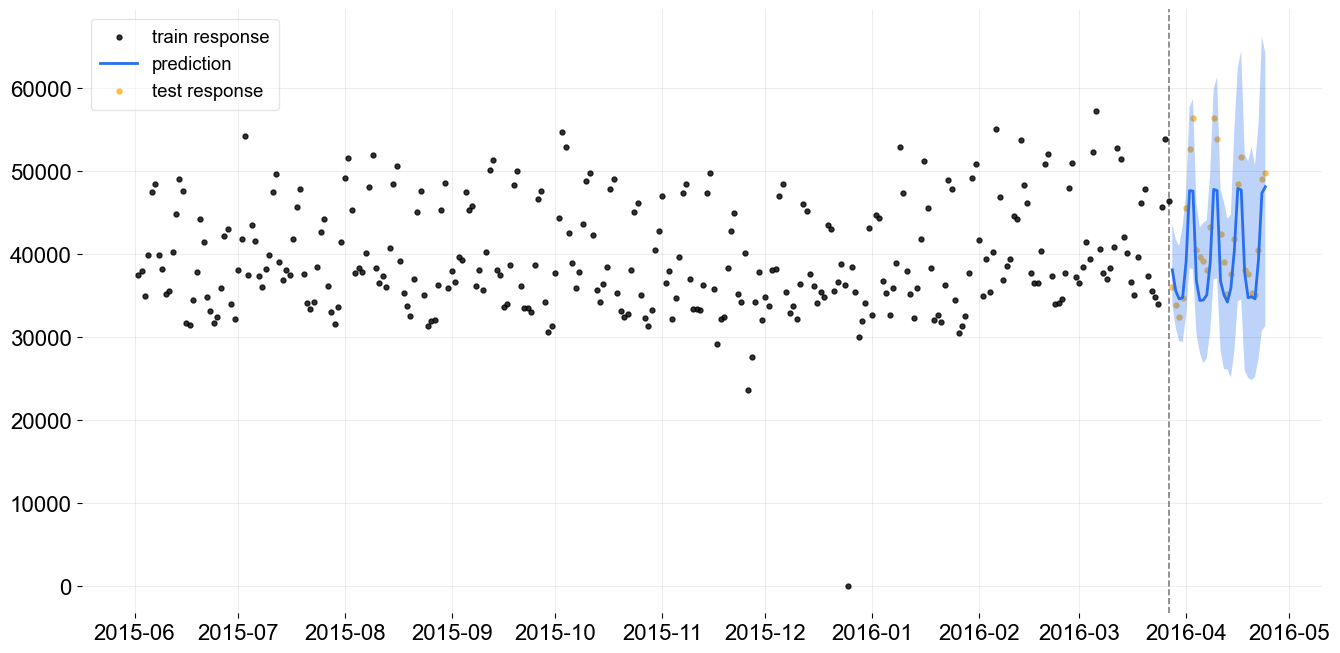

In [30]:
pred_df = dlt.predict(test_df)
# reverse transformation for prediction
pred_df[['prediction_5', 'prediction', 'prediction_95']] = \
  pred_df[['prediction_5', 'prediction', 'prediction_95']].apply(np.exp) * m
# plot last 300 observations from train only
plot_predicted_data(train_df[-300:], pred_df, 'date', 'sales', 'prediction', test_actual_df=test_df);

## Example II - Turkish Daily Electricity

Another example is the Turkish daily electricity demand data posted by Rob Hyndman. In this case, the seasonality is relatively smooth compared to the previous dataset.

In [31]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()
date_col = 'date'
response_col = 'electricity'
df[response_col] = np.log(df[response_col])
print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.437595
1,2000-01-02,9.501295
2,2000-01-03,9.635649
3,2000-01-04,9.653920
4,2000-01-05,9.660890


In [33]:
df, fs_cols = make_fourier_series_df(df, 365.25, order=3)
m = df['electricity'][0]
df['y'] = np.log(df['electricity']/m)

In [34]:
test_size = 365
train_df = df[:-test_size]
test_df = df[-test_size:]

Note that due to the smoothness of the true seasonality, this hits the limit of **DLT(as well as LGT)** with the issue of [degeneracy](https://en.wikipedia.org/wiki/Degeneracy_(mathematics)) where the sampling algorithm has a hard time distinguish between the update of seasonality and the update of level (and the correspondent smoothing parameters). Hence, a suggestion here is to provide a fixed smoothing parameters by setting the args `level_sm_input=0.001`. In general, values less than `0.1` work well with this type of problem. To further optimize the value, one can leverage the hyper-parameters tuning function provided by the package (see the section discussing `Backtester` and `grid_search`).

In [77]:
%%time
dlt = DLT(
    date_col='date',
    response_col='y',
    regressor_col=fs_cols,
    seasonality=7,
    seed=2020,
    level_sm_input=0.001,
    estimator='stan-mcmc',
)
dlt.fit(train_df)

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.0, warmups(per chain):225 and samples(per chain):25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 741 ms, sys: 567 ms, total: 1.31 s
Wall time: 4min 59s


predict and plot the result.

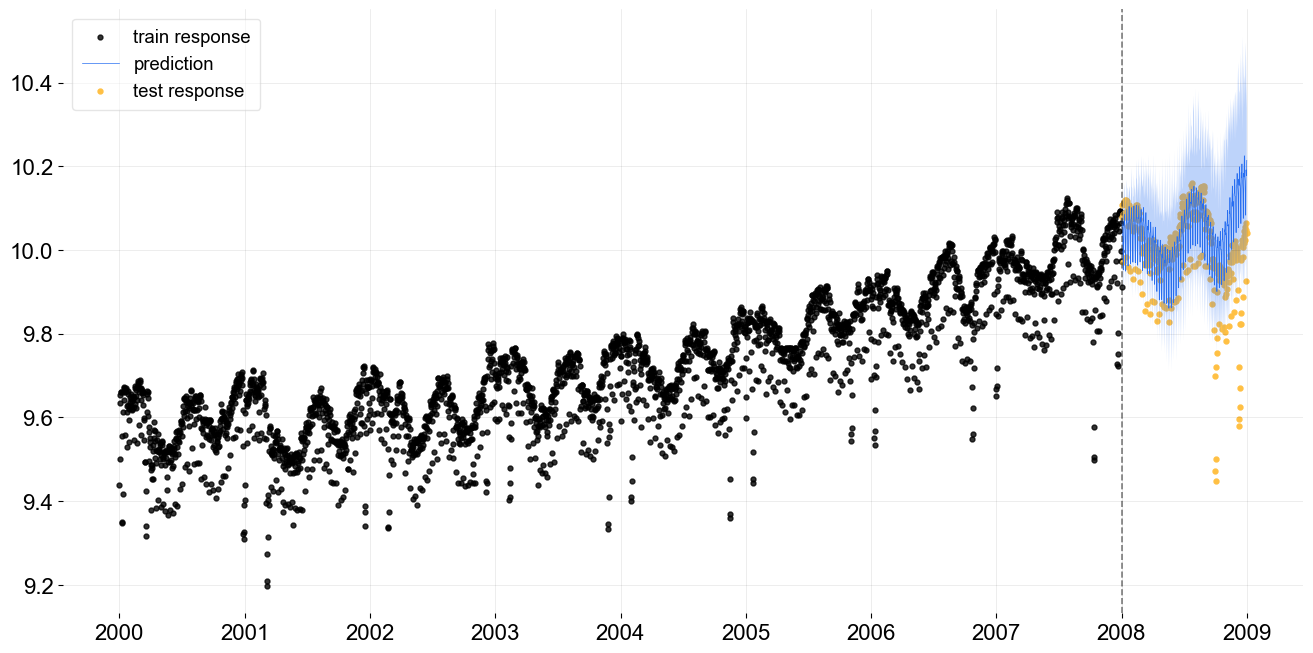

In [79]:
pred_df = dlt.predict(test_df)
pred_df[['prediction_5', 'prediction', 'prediction_95']] = \
  pred_df[['prediction_5', 'prediction', 'prediction_95']].apply(np.exp) * m
plot_predicted_data(train_df, pred_df, 'date', 'electricity', 'prediction', test_actual_df=test_df, lw=0.5);

## Conclusion

In this article, we provide a work around solution to use **DLT** to model data with complex seasonality. One can combine the usage of hyper-parameters tuning to further optimize the smoothing parameters.  Alternatively, users can consider solution such as **dynamic harmonic regression** or the **KTR(another model provided in Orbit)**.

## References

1. Young, P. C., Pedregal, D. J., & Tych, W. (1999). Dynamic harmonic regression. Journal of Forecasting, 18, 369–394.\[[DOI](https://doi.org/10.1002/(SICI)1099-131X(199911)18:6%3C369::AID-FOR748%3E3.0.CO;2-K)\]